In [1]:
from argparse import ArgumentParser
import os
import sys
import time

import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import piecewise_regression
import rasterio
# import scipy
import seaborn as sns
import shapely
import xarray as xr

# from matplotlib import colors
from matplotlib.ticker import MaxNLocator
from pandarallel import pandarallel

from reaches import *
from utils import *

## For plotting

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [3]:
cmap = plt.get_cmap('cubehelix')
new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [4]:
# cmap = plt.get_cmap('cubehelix', 5)
# new_cmap = truncate_colormap(cmap, 0.2, 0.75)

In [5]:
# color = []

# for i in np.linspace(0, 1, 3):
#     color.append(colors.rgb2hex(new_cmap(i)))

In [6]:
# palette = sns.color_palette(color)

### Parse arguments

In [7]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
    binn = 'Bin'
elif width_set == 'min':
    width = 'WidthM_Min'
    binn = 'Bin_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
    binn = 'Bin_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [8]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/fiona/data/PIXC_v2_0_HUC2_' + huc2
# save_dir =

### Pixel Cloud

In [9]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [10]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [11]:
file_name = data[index]

In [12]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [13]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [14]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [15]:
# ds_PIXC.load_tide_fes

In [16]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(761047,)


In [17]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid', 'solid_earth_tide', ## HERE
             'load_tide_fes', 'pole_tide', 'prior_water_prob', ## HERE
             'classification']

In [18]:
# Convert PIXC to GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

### Find correct HUC4s

In [19]:
### NHDPlus HR
## Find correct HUC4s
# Read in tile and HUC4 intersection data
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [20]:
# Make list of HUC4s that intersect the tile
hucs = list(tile_huc4[(tile_huc4['tile'] == tile_name)]['huc4'])
# Limit to the current HUC2
hucs = [x for x in hucs if x.startswith(huc2)]

In [21]:
hucs

['0101', '0102', '0105']

In [22]:
# Get NHD index metadata
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
huc_lookup = pd.read_csv(os.path.join(mdata_path,
                                  'HUC4_lookup_no_great_lakes.csv'),
                     dtype=dtype_dic)

In [23]:
# Extract indices for read-in
indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in HUC4 flowliness

In [24]:
# Create merged dataframe of all flowlines intersected
if len(indices) == 1:
    # Read prepped NHD
    flowlines, _, _,  = readNHD(index=indices[0])
    # huc4_list, huc2_list = readNHD(index=indices[0])
else:
    # Initialize lists
    d = []
    # huc4_list = []
    # huc2_list = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        flowlines, _, _ = readNHD(index=i)
        # huc4, huc2 = readNHD(index=i)
        # Append to lists
        d.append(flowlines)
        # huc4_list.append(huc4) # I DON'T DO ANYTHING WITH THIS
        # huc2_list.append(huc2) # I DON'T DO ANYTHING WITH THIS
    # Merge GeoDataFrames
    flowlines = pd.concat(d)

type: normal
NHDPLUS_H_0101_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0102_HU4_GDB
flowlines read-in
exploded
type: normal
NHDPLUS_H_0105_HU4_GDB
flowlines read-in
exploded


In [25]:
# Project CRS (currently to WGS 84 / UTM zone 18N) 
flowlines = flowlines.to_crs(epsg=3857)

In [26]:
pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [27]:
start = time.time()
# Args are the width, cap_style, segmented=False, extra=False
# Buffering with extra distance to capture pixels that would overlap
# once converted to pseudo-pixels
flowlines['buffer'] = flowlines.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', False, True),
                                                         axis=1)
end = time.time()
print(end - start)

9.843502521514893


In [28]:
# Set geometry to buffered reaches
flowlines = flowlines.set_geometry('buffer').set_crs(epsg=3857)

In [29]:
# flowlines.crs

In [30]:
# Clip masked pixels to buffered reaches
gdf_PIXC_clip = gpd.sjoin(gdf_PIXC, flowlines, how='inner', predicate='within')

In [31]:
if gdf_PIXC_clip.shape[0] == 0:
    print('This granule has no pixels that intersect reaches, exiting.')
    # sys.exit() 

In [32]:
# Drop unneeded cols
gdf_PIXC_clip = gdf_PIXC_clip.drop(columns=['index_right', 'NHDPlusID',
                                            'GNIS_Name', 'LengthKM',
                                            'WidthM', 'WidthM_Min',
                                            'WidthM_Max', 'Bin', 'Bin_Min',
                                            'Bin_Max', 'geometry_right',
                                            'StreamOrde']).reset_index() ### HERE

### Nadir track

In [33]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC_clip.iloc[0].geometry

In [34]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Make pseudo pixels

In [35]:
# Set along-track pixel resolution
azimuth_res = 22 # meters

In [36]:
# Make pseudo pixels
start = time.time()
gdf_PIXC_clip['pseudo_pixel'] = gdf_PIXC_clip.parallel_apply(user_defined_function=makePseudoPixels,
                                                         args=(nadir_segment_ln,
                                                               azimuth_res),
                                                         axis=1)
end = time.time()
print(end - start)

2.5499281883239746


In [37]:
gdf_PIXC_clip = gdf_PIXC_clip.rename(columns={'geometry': 'pixel_centroid'}).set_geometry('pseudo_pixel').set_crs(epsg=3857)

In [38]:
# Get bounds of PIXC tile
pseudo_bounds = gdf_PIXC_clip.total_bounds
# Copy geometry column as sjoin will discard it
gdf_PIXC_clip['pseudo_geom'] = gdf_PIXC_clip.geometry

### Read in segments

In [39]:
# Create merged dataframe of all basins intersected
if len(indices) == 1:
    # Read prepped NHD
    segments, _, _ = readNHD(index=indices[0], segmented=True)
else:
    # Initialize lists
    d = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        segments, huc4, _ = readNHD(index=i, segmented=True)
        # Make column with HUC4 id
        segments['huc4_long'] = huc4
        segments['huc4'] = segments['huc4_long'].str[10:14]
        # Rename segments to geometry
        # segments = segments.rename(columns={'segments': 'geometry'}).set_geometry('geometry')
        # Append to list
        d.append(segments)
    # Merge GeoDataFrames
    segments = pd.concat(d)

type: segmented
NHDPLUS_H_0101_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0101_HU4_GDB_prepped_segmented.parquet
segments read-in
type: segmented
NHDPLUS_H_0102_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_segmented.parquet
segments read-in
type: segmented
NHDPLUS_H_0105_HU4_GDB
/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_segmented/HUC2_01/NHDPLUS_H_0105_HU4_GDB_prepped_segmented.parquet
segments read-in


In [40]:
# Project CRS (currently to WGS 84 / UTM zone 18N)
segments = segments.to_crs(epsg='3857')

In [41]:
segments = segments.reset_index().rename(columns={'index': 'index_old'})

In [42]:
# Assign a unique counter within each index group
segments['counter'] = segments.groupby('NHDPlusID').cumcount()

In [43]:
# Keep only first ten segments (some reaches repeat)
segments = segments[segments['counter'] < 10]

# For HUC4_0109, 5000700035256 and 5000700072690

In [44]:
segments = segments.clip(pseudo_bounds)

In [45]:
# Keep only reaches that are fully contained in PIXC granule
segments = segments.groupby('NHDPlusID').filter(lambda x: len(x) == 10)

In [46]:
# segments.sort_values(by=['NHDPlusID', 'counter']).iloc[1009]['segments'].coords.xy

In [47]:
# ax = segments.sort_values(by=['NHDPlusID', 'counter']).iloc[1000:1010].plot(cmap=new_cmap)
# # ctx.add_basemap(ax, source=ctx.providers.Stadia.Stame)

In [48]:
# segments[segments['NHDPlusID'] == 5000200027147].plot(cmap=new_cmap)

In [49]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)
# segments['buffered'] = segments.buffer(distance=(segments.WidthM/2), cap_style='flat')

1.6556150913238525


In [50]:
segments = segments.set_geometry('buffer').set_crs(epsg=3857)

In [51]:
# Calculate segment area
segments['segment_area'] = segments.geometry.area

In [52]:
test = gpd.sjoin(segments, gdf_PIXC_clip, predicate='intersects').sort_values(by=['NHDPlusID', 'counter']).reset_index().drop(columns=['level_0', 'index_old']) # [['NHDPlusID', 'counter', 'GNIS_Name', 'height']]

In [53]:
for_height = [3, 4, 6, 7]

In [54]:
test = test[test.klass.isin(for_height)].reset_index().drop(columns='level_0')

In [55]:
test['wse'] = test.height - test.geoid - test.solid_earth_tide - test.load_tide_fes - test.pole_tide

In [56]:
def project_point(line, point):
    # Project point onto line
    return line.project(point)

In [57]:
test.shape

(8795, 34)

In [58]:
test = pd.merge(left=test, right=flowlines[['NHDPlusID', 'geometry']])

In [59]:
test = test.rename(columns={'geometry': 'flowline'})

In [60]:
test['distance'] = test.apply(lambda x: project_point(x['flowline'], x['pixel_centroid']), axis=1)

In [61]:
ids = test['NHDPlusID'].unique()

In [62]:
data_path = './figures_for_2025_03_17/'

In [63]:
palette = {2: 'forestgreen', 3: 'cornflowerblue', 4: 'blue', 5: 'hotpink',
           6: 'darkkhaki', 7: 'springgreen'} # 6: 'lightsalmon', 7: 'lightblue'

In [64]:
# Make dict for legend labels
flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
codes = {str(idx) + '.0':k for idx, k in enumerate(flags, start=1)}

In [65]:
codes

{'1.0': 'land',
 '2.0': 'land_near_water',
 '3.0': 'water_near_land',
 '4.0': 'open_water',
 '5.0': 'dark_water',
 '6.0': 'low_coh_water_near_land',
 '7.0': 'open_low_coh_water'}

In [66]:
test.columns

Index(['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'WidthM_Min',
       'WidthM_Max', 'Bin', 'segments', 'Bin_Min', 'Bin_Max', 'huc4_long',
       'huc4', 'counter', 'buffer', 'segment_area', 'index_right0', 'index',
       'points', 'azimuth_index', 'range_index', 'cross_track', 'pixel_area',
       'height', 'geoid', 'solid_earth_tide', 'load_tide_fes', 'pole_tide',
       'prior_water_prob', 'klass', 'latitude', 'longitude', 'pixel_centroid',
       'pseudo_geom', 'wse', 'flowline', 'distance'],
      dtype='object')

Text(0, 0.5, 'WSE [m]')

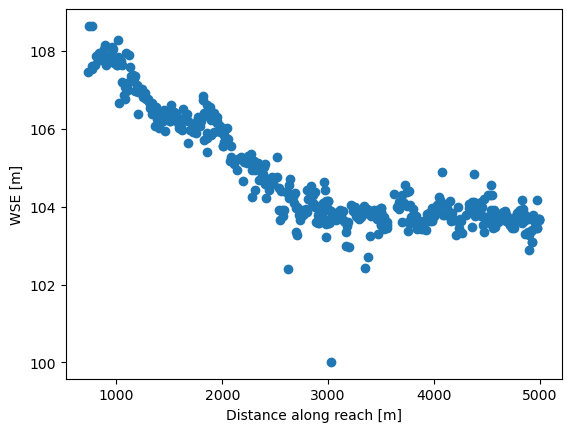

In [136]:
# data = test[test['NHDPlusID'] == ids[30]].sort_values(by='distance')#.drop_duplicates(subset='distance')
data = test[test['NHDPlusID'] == 5000200008760].sort_values(by='distance')
x = np.array(data['distance'])
y = np.array(data['wse'])

plt.scatter(x=x, y=y)
plt.xlabel('Distance along reach [m]')
plt.ylabel('WSE [m]')

In [137]:
pw_fit = piecewise_regression.ModelSelection(x, y, max_breakpoints=6)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 
Running fit with n_breakpoint = 3 . . 
Running fit with n_breakpoint = 4 . . 
Running fit with n_breakpoint = 5 . . 
Running fit with n_breakpoint = 6 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     -274.5         True       249.22 
1                    -859.27         True       68.637 
2                    -858.59         True       66.939 
3                     -884.6         True       61.627 
4                     -881.1         True        60.47 
5                    -877.25         True       59.379 
6                     -870.0         True       58.738 

Min BIC (Bayesian Information Criterion) suggests best model


Plotting fit for model with 1 breakpoint(s) . . . 


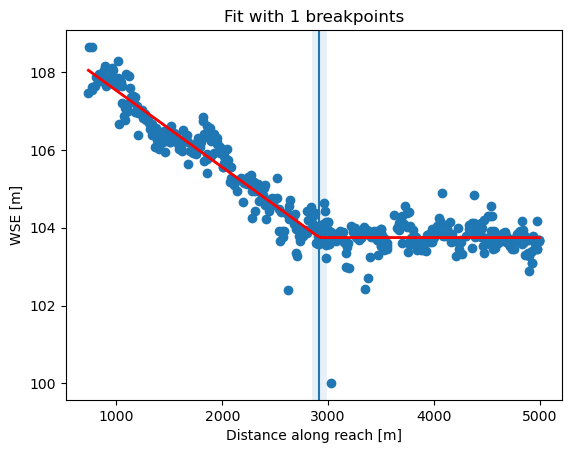

In [148]:
model = pw_fit.models[0]

print("Plotting fit for model with {} breakpoint(s) . . . ".format(model.n_breakpoints))
model.plot()
pw_fit.models[0].plot_fit(color="red", linewidth=2)
plt.xlabel('Distance along reach [m]')
plt.ylabel('WSE [m]')
plt.title("Fit with {} breakpoints".format(model.n_breakpoints))
plt.show()

In [133]:
# pw_fit = piecewise_regression.Fit(x, y, start_values=[5], n_breakpoints=2)

In [132]:
# pw_fit.summary()

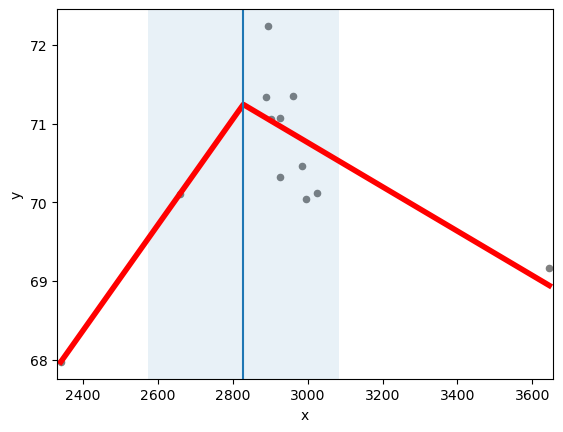

In [76]:
pw_fit.models[0].plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.models[0].plot_fit(color="red", linewidth=4)
pw_fit.models[0].plot_breakpoints()
pw_fit.models[0].plot_breakpoint_confidence_intervals()
plt.xlim(x.min()-10, x.max()+10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()
plt.close()

In [81]:
spl = make_splrep(x=x, y=y, k=1, s=0.90)

In [82]:
xs = np.linspace(x.min(), x.max(), 1000)

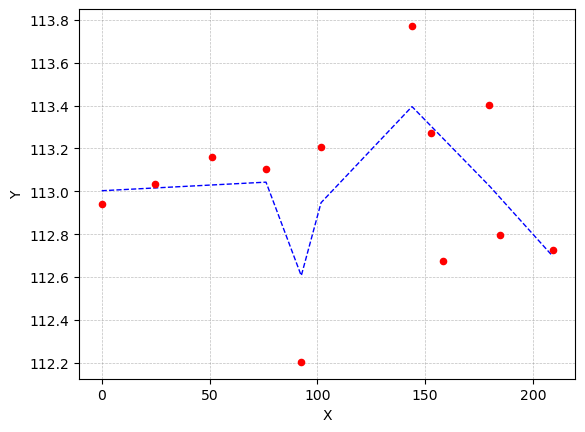

In [83]:
fig, ax = plt.subplots()
ax.scatter(x, y, color="red", s=20, zorder=20)
ax.plot(xs, spl(xs), linestyle="--", linewidth=1, color="blue", zorder=10)
ax.grid(color="grey", linestyle="--", linewidth=.5, alpha=.5)
ax.set_ylabel("WSE [m]")
ax.set_xlabel("Distance along reach [m]")
plt.show()

In [ ]:
for id_ in ids:

    data=test[test['NHDPlusID'] == id_]
    if data.shape[0] > 3:

        # fig, ax = plt.subplots(figsize=(10,7))
        # sns.regplot(data=data,
        #                 x='distance', y='wse',
        #             column='klass', palette=new_cmap
        #            )
        
        graph = sns.lmplot(data=data,
                           x='distance', y='wse',
                           hue='klass', palette=palette, fit_reg=False,
                           height=7, aspect=1.42, legend=False)
        sns.regplot(data=data, x='distance', y='wse',
                    color='gray',
                    scatter=False,ax=graph.axes[0, 0])
        
        # Get the axes object
        ax = graph.axes[0, 0]

        # Get the handles and labels
        handles, labels = ax.get_legend_handles_labels()

        # Update the labels
        new_labels = [codes[label] for label in labels]

        # Update the legend
        ax.legend(handles, new_labels,
                  title='Classification', loc='upper right')
        
        plt.xlabel('Distance along reach [m]')
        plt.ylabel('WSE [m]')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.title('NHDPlusID: ' + str(id_.astype('int')) +
                  ', width: ' + str(round(data.iloc[0]['WidthM'], 2)) +
                  ' [m], length: ' + str(round(data.iloc[0]['LengthKM'], 2)) +
                  ' [km]')
        
        plt.savefig(data_path + str(id_.astype('int')) + '.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=test[test['NHDPlusID'] == 5000200001544],
                x='counter', y='wse'
            # hue='counter', palette=new_cmap
           )

plt.xlabel('Node')
plt.ylabel('WSE [m]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=test[test['NHDPlusID'] == 5000200006404],
                x='counter', y='wse'
            # hue='counter', palette=new_cmap
           )

plt.xlabel('Node')
plt.ylabel('WSE [m]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
fig, ax = plt.subplots()
sns.regplot(data=test[test['NHDPlusID'] == 5000200001746],
                x='counter', y='wse'
            # hue='counter', palette=new_cmap
           )

plt.xlabel('Node')
plt.ylabel('WSE [m]')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# Merge the segments and pseudo-puxels by intersection
sj = gpd.sjoin(segments, gdf_PIXC_clip, how='left', predicate='intersects')

In [ ]:
sj.columns

In [ ]:
sj = sj.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index',
                      # 'height', 'geoid',
                      # 'klass',
                      'latitude', 'longitude'])

In [ ]:
sj

In [ ]:
sj = sj.set_geometry('pseudo_geom')

In [ ]:
sj = sj.groupby('NHDPlusID', as_index=False).parallel_apply(user_defined_function=specialDissolve)

In [ ]:
sj = sj.reset_index().drop(columns=['level_0', 'level_1'])

In [ ]:
sj['pseudo_geom_clip'] = sj.parallel_apply(user_defined_function=specialClip,
                                                         axis=1)

In [ ]:
# sj[sj['NHDPlusID'] == 10000900090399].pseudo_geom.plot(cmap='hsv')

In [ ]:
# Calculate the pseudo-pixel area within each node
sj['pseudo_area'] = sj.pseudo_geom_clip.area

In [ ]:
sj['coverage'] = sj.pseudo_area/sj.segment_area

In [ ]:
# sj_w_zero = sj.copy()

In [ ]:
# sj_w_zero['coverage'] = sj_w_zero['coverage'].fillna(0)
sj['coverage'] = sj['coverage'].fillna(0)

### Do stats

In [ ]:
bins = sj.Bin.unique()

#### Reaches

In [ ]:
reaches_cent, reaches_thresh, reaches_min = summarizeCoverage(df=sj, binn=binn,
                                            bins=bins, counts=counts)

In [ ]:
reaches_min

In [ ]:
reaches_min.sort_values(by=['NHDPlusID'])[::10]

In [ ]:
# d = {}
# # d_q = {}
# for i in range(1, 10):
#     threshold = i/10
#     # print(threshold)
    
#     detected = sj.groupby([binn, 'NHDPlusID'])['coverage'].apply(lambda x: (x > threshold).sum()) / 10
#     reach = detected.reset_index()
    
#     # reach = detected.groupby(binn).quantile(q=[x / 100.0 for x in range(0,100,1)]).reset_index()
        
#     d[threshold] = reach

In [ ]:
# Add a column for each DataFrame indicating the key
# for threshold, data in d.items():
#     data['threshold'] = threshold
    
for threshold, data in d.items():
    data['threshold'] = threshold

In [ ]:
# Concatenate all DataFrames into one
# reaches_desc = pd.concat(d.values())

reaches_cent = pd.concat(d.values()).rename(columns={'level_1': 'centile'})

In [ ]:
reaches_cent

In [ ]:
# reaches_cent = pd.merge(left=reaches_cent, right=counts, how='left', on=binn)

In [ ]:
reaches_cent

In [ ]:
reaches_min = pd.DataFrame(sj.groupby('NHDPlusID')['coverage'].min()).reset_index()

In [ ]:
reaches_min = pd.merge(left=reaches_min, right=sj[['NHDPlusID', binn]], how='left', on='NHDPlusID')

In [ ]:
min_cov

In [ ]:
# reaches = pd.DataFrame(data=d).T

In [ ]:
# reaches.columns = bins

### Write out

In [ ]:
save_path = os.path.join('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/', 'PIXC_v2_0_HUC2_01')

In [ ]:
# Combine node_desc
node_desc_both = pd.concat([node_desc, node_desc_w_zero], ignore_index=True)
node_desc_both

In [ ]:
# Combine node_quant
node_quant_both = pd.concat([node_quant, node_quant_w_zero], ignore_index=True)
node_quant_both

In [ ]:
# nodes_desc_both.to_csv(os.path.join(save_path, granule_name + '_nodes_describe.csv'))
# nodes_quant_both.to_csv(os.path.join(save_path, granule_name + '_nodes_quantile.csv'))

In [ ]:
# reaches_desc.to_csv(os.path.join(save_path, granule_name + '_reaches_describe.csv'))
# reaches_quant.to_csv(os.path.join(save_path, granule_name + '_reaches_quantile.csv'))

In [ ]:
test = pd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_01_2025_03_02_min/SWOT_L2_HR_PIXC_004_242_074L_20230930T103957_20230930T104008_PGC0_01_reaches_thresh.parquet')

In [ ]:
test